# Regresia logistică

[1] [Cross entrppy for dummies](https://towardsdatascience.com/cross-entropy-for-dummies-5189303c7735)

[2] [Understanding logistic regression](https://towardsdatascience.com/understanding-logistic-regression-step-by-step-704a78be7e0a)

[3] [Cross entropy log loss and intuition behind it](https://towardsdatascience.com/cross-entropy-log-loss-and-intuition-behind-it-364558dca514)

[4] [Cross entropy (a se vedea secţiunea "Relation with log-likelihood")](https://en.wikipedia.org/wiki/Cross_entropy)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import csv
import functools
import tableprint as tab
import pandas as pd

plt.rc('font', **{'size' : 18})

# Încărcarea setului de date

In [3]:
train_set = pd.read_csv('mnist_train.csv').values
test_set = pd.read_csv('mnist_test.csv').values

In [4]:
# train_set si test_set sunt matrici care contin pe prima coloana clasa (o cifra de la 0 la 9),
#  iar imaginea este pastrata incepand de pe coloana 1 pana la terminare.
# Decupati in train_x doar imaginile iar in train_y doar clasa,
#  si faceti acelasi lucru si pentru test_x si test_y
train_x, train_y = train_set[:, 1:], train_set[:, 0]
test_x, test_y = test_set[:, 1:], test_set[:, 0]

assert train_x.shape == (59999, 784)
assert train_y.shape == (59999,)
assert test_x.shape == (9999, 784)
assert test_y.shape == (9999,)

Să vizualizăm setul de date. Vom observa primele 16 linii din setul de antrenare:

(16, 784) (16,)


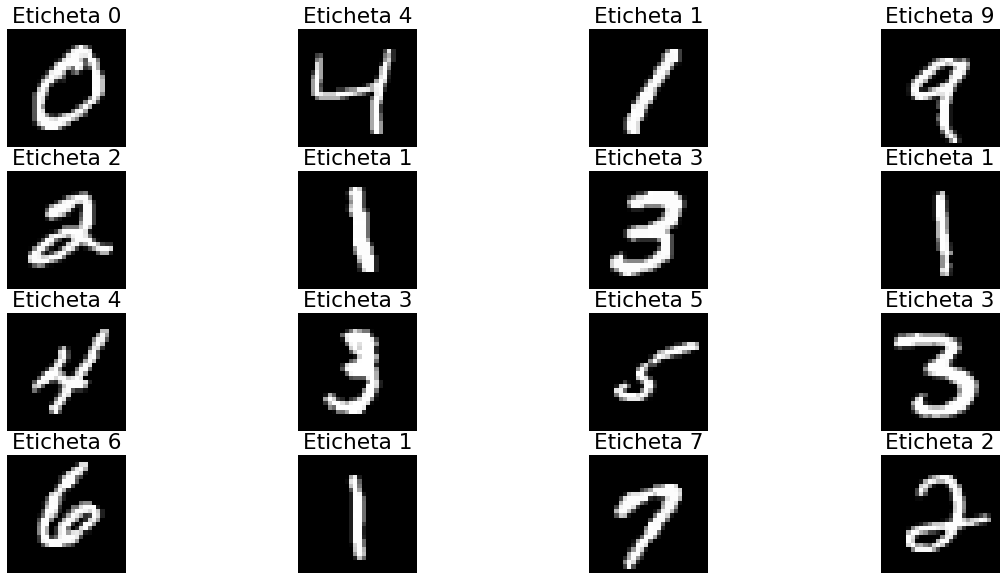

In [5]:
def show_samples(x_set, y_set):
    size = x_set.shape[0]
    
    fig, ax = plt.subplots(size // 4, 4, figsize=(20, 10))
    for k in range(size):
        row, col = k // 4, k % 4
        
        # Make those columns into a array of 8-bits pixels
        # The pixel intensity values are integers from 0 to 255
        pixels = np.array(x_set[k], dtype='uint8')    
        
        # Reshape the array into 28 x 28 array (2-dimensional array)
        n = int(np.sqrt(len(pixels)))
        assert n**2 == len(pixels)
        pixels = pixels.reshape(n, n)
        ax[row, col].imshow(pixels, cmap='gray')
        ax[row, col].set_title('Eticheta {label}'.format(label=y_set[k]))
        ax[row, col].axis('off')

    plt.show()
print(train_x[:16].shape, train_y[:16].shape)
show_samples(train_x[:16], train_y[:16])

Pentru regresia binomială, ne interesează să clasificăm deocamdată doar imaginile corespunzătoare a două clase, pentru cifrele '0' şi '1'. Vom defini seturile care 'decupează' doar aceste două clase din seturile date:

In [30]:
train_x_bin, train_y_bin = train_x[train_y <= 1], train_y[train_y <= 1].reshape(-1, 1)

test_x_bin, test_y_bin = test_x[test_y <= 1], test_y[test_y <= 1].reshape(-1, 1)

assert train_x_bin.shape == (12665, 784)
assert train_y_bin.shape == (12665, 1)
assert test_x_bin.shape == (2115, 784)
assert test_y_bin.shape == (2115, 1)

 La fel ca si la regresia liniară, prima coloană trebuie să fie formată doar din cifra 1:

In [31]:
def add_ones_column(x):
    """
    Adds a column of ones to x
    """
    x = np.concatenate((np.ones((x.shape[0], 1)), x), axis = 1)
    return x

train_x_bin_ext = add_ones_column(train_x_bin)
test_x_bin_ext = add_ones_column(test_x_bin)

assert train_x_bin_ext.shape == (12665, 785)
assert test_x_bin_ext.shape == (2115, 785)
assert np.all(train_x_bin_ext[:, 0] == 1)
assert np.all(test_x_bin_ext[:, 0] == 1)

Feature-urile trebuiesc normalizate, valoarea maximă fiind 255. Normalizarea urmăreşte ca toate featurile rezultate să fie în intervalul \[0, 1\], deci vom împărţi la valoarea maximă.

In [32]:
def normalize(x):
    """
    Normalization means division by 255
    
    Args:
        x: matricea feature-urilor, dimensiune m x n
    
    Returns:
        matricea cu valorile normalizate in in [0, 1], dimensiune m x n
    """

    return x / 255.0

train_x_bin_ext = add_ones_column(normalize(train_x_bin))
test_x_bin_ext = add_ones_column(normalize(test_x_bin))

assert train_x_bin_ext.shape == (12665, 785)
assert test_x_bin_ext.shape == (2115, 785)
assert np.all(train_x_bin_ext[:, 0] == 1)
assert np.all(test_x_bin_ext[:, 0] == 1)
assert np.all(train_x_bin_ext <= 1)
assert np.all(test_x_bin_ext <= 1)
assert np.all(train_x_bin_ext >= 0)
assert np.all(test_x_bin_ext >= 0)

Calculăm funcţia sigmoidă, $sigmoid(z) = \frac{1}{1 + e^{-z}}$ respectiv $h(x, \theta) = sigmoid \left( \frac{1}{1 + e^{-X  \theta}} \right)$:

In [33]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

assert sigmoid(0) == 0.5
assert np.abs(sigmoid(1) - 0.731058) < 1e-6

def h(x, theta):
    return sigmoid(np.dot(x, theta))

assert np.abs(h(np.array([1., 1., 1., 0]), np.array([1., 0., 1., 1.])) - 0.880797) < 1e-6

Calculăm funcţia de cost cu regularizare de data aceasta (atenţie, coeficientul $\theta_0$ nu se regularizează):

$$J(\theta) = \frac{1}{m} \mathbb{1}_m^T \left\{ - Y \odot \ln[h(X \theta)] - (\mathbb{1}_m-Y) \odot \ln[\mathbb{1}_m-h(X \theta)] \right\} + \frac{\lambda}{2} \sum_{i=1}^{n-1} \|\theta_i\|^2$$

Am folosit aici notaţia $\odot$, ce specifică produsul Hadamard, element cu element. Pentru a realiza înmulţirea dintre matricea $X$ de dimensiune $(m, n)$ şi vectorul $\theta$ de dimensiune $(n, 1)$, produsul de matrici $X \cdot \theta$ este considerat implicit.

In [34]:
def cost(x, y, theta, lmbda):
    """
    Cost function includes also regularization
    
    Args:
        x: matricea feature-urilor, dimensiune m x n
        y: vectorul evidentei, dimensiune m
        theta: vectorul coeficientilor, dimensiune n
        
    Returns:
        costul, ca scalar
    """
    cost = np.multiply(y, np.log(h(x, theta))) + \
            np.multiply((np.ones((y.size, 1)) - y), np.log(np.ones((y.size, 1)) - h(x, theta)))
    return -1 / y.size * (np.dot(np.ones(y.size).T, cost)).sum() + lmbda / 2.0 * np.sum(theta[1:] ** 2)

np.random.seed(11)
n = train_x_bin_ext.shape[1]
theta = np.random.randn(n).reshape(n, 1)
assert np.abs(cost(train_x_bin_ext, train_y_bin, theta=theta, lmbda=0.2) - 79.815566) < 1e-6

Calculăm gradientul, folosind expresia determinată anterior, şi ţinând seama de termenul de regularizare:

$$\nabla_{\theta} J(X, Y, \theta) = \frac{1}{m} \mathbb{1}_m^T \left\{ \left[ h(X \theta) - Y\right] \odot X \right\} + \lambda [0, \theta_{1..n-1}]$$

In [35]:
def deltas(x, y, theta, lmbda):
    """
    Computation of gradient with regularization term
    
    Args:
        x: matricea feature-urilor, dimensiune m x n
        y: vectorul evidentei, dimensiune m
        theta: vectorul coeficientilor, dimensiune n
        lmbda: coeficientul de regularizare
        
    Returns:
        gradientul, vector de n elemente
    """
    regularization = lmbda * np.concatenate(([[0]], theta[1:]), axis = 0)
    return 1 / y.size * np.dot(np.ones(y.size), (h(x, theta) - y) * x).reshape(theta.shape[0], 1) + regularization

np.random.seed(11)
n = train_x_bin_ext.shape[1]
theta = np.random.randn(n).reshape(n, 1)
res = deltas(train_x_bin_ext, train_y_bin, theta=theta, lmbda=0.2)
assert res.shape == (785, 1)

Algoritmul de antrenare va stoca costul asociat fiecărei epoci într-o listă:

In [36]:
def compute_accuracy(x_set, y_set, theta):
    pred = ((h(x_set, theta) >= 0.5) * 1 == y_set)
    return 100.0 * sum(pred) / pred.shape[0]

In [37]:
# Set learning rate
eta = 0.2

# Set regularization coefficient
lmbda = 0.5

# In x, we have m instances of n features each
# Create theta as a vector (n x 1)
n = np.shape(train_x_bin_ext)[1]
theta = np.random.randn(n).reshape(n, 1)

# Do the training
epochs = 40
values = []
accurracies = []
for i in range(epochs):
    theta -= eta * deltas(train_x_bin_ext, train_y_bin, theta, lmbda)
    acc = compute_accuracy(train_x_bin_ext, train_y_bin, theta)
    values.append(cost(train_x_bin_ext, train_y_bin, theta, lmbda))
    accurracies.append(acc)
    
print("last cost: %g" % values[-1])

last cost: 0.273241


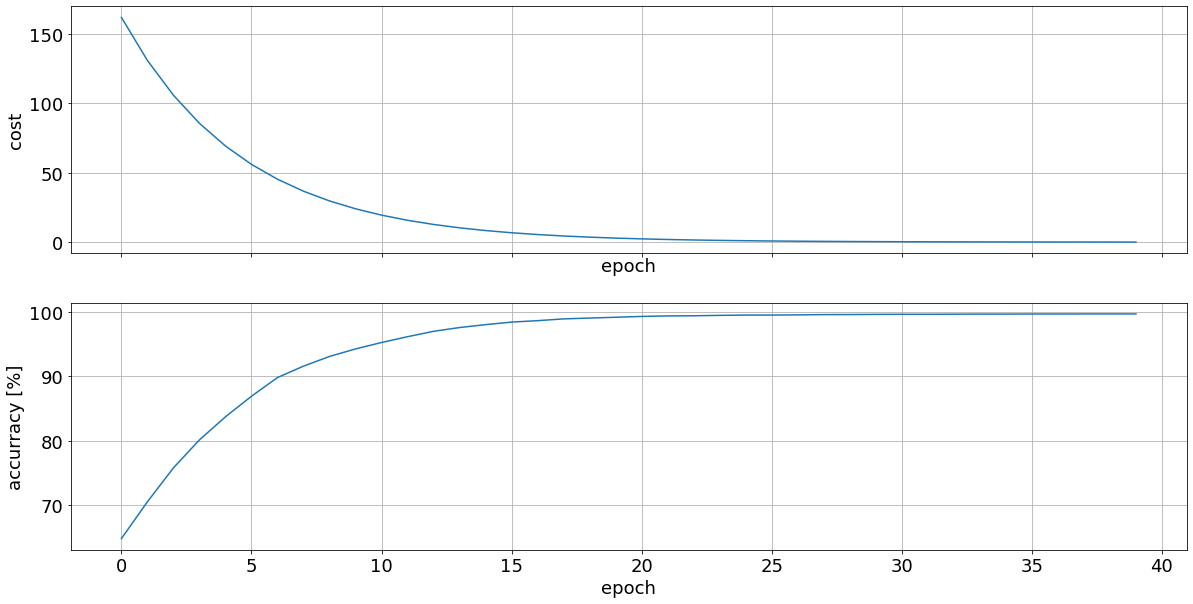

In [38]:
fig, ax = plt.subplots(2, 1, figsize=(20, 10), sharex=True)
ax[0].plot(range(len(values)), values)
ax[0].set_xlabel('epoch') ; ax[0].set_ylabel('cost')
ax[0].grid()
ax[1].plot(range(len(accurracies)), accurracies)
ax[1].set_xlabel('epoch') ; ax[1].set_ylabel('accurracy [%]')
ax[1].grid()
plt.show()

In [39]:
# Calculam acuratetea pentru setul de test
# Aceasta presupune sa numaram cate predictii se potrivesc cu realitatea si sa exprimam acest lucru procentual
pred = ((h(test_x_bin_ext, theta) >= 0.5) * 1 == test_y_bin)
print("accuracy: %2.2f%% for %d patterns" % (100.0 * np.average(pred) , test_x_bin_ext.shape[0]))

# Calculam confusion matrix
# true positive: y = 1 and pred = 1
# true negative: y = 0 and pred = 0
# false positive: y = 0 and pred = 1
# false negative: y = 1 and pred = 0
pred = (h(test_x_bin_ext, theta) >= 0.5) * 1
tp = np.sum(np.logical_and(pred == 1, test_y_bin == 1))
tn = np.sum(np.logical_and(pred == 0, test_y_bin == 0))
fp = np.sum(np.logical_and(pred == 1, test_y_bin == 0))
fn = np.sum(np.logical_and(pred == 0, test_y_bin == 1))

headers = ['Confusion Matrix', 'pred: 0', 'pred: 1', 'pred: all'] 
table = [
    ['actual: 0', tn, fp, tn + fp],
    ['actual: 1', fn, tp, fn + tp],
    ['actual: all', tn + fn, fp + tp, tn + fn + fp + tp]]
tab.table(table, headers, width=16)

accuracy: 99.86% for 2115 patterns
╭──────────────────┬──────────────────┬──────────────────┬──────────────────╮
│ Confusion Matrix │          pred: 0 │          pred: 1 │        pred: all │
├──────────────────┼──────────────────┼──────────────────┼──────────────────┤
│        actual: 0 │              978 │                2 │              980 │
│        actual: 1 │                1 │             1134 │             1135 │
│      actual: all │              979 │             1136 │             2115 │
╰──────────────────┴──────────────────┴──────────────────┴──────────────────╯


## 4. Regresia logistică multinomială

In [40]:
# classes
k = 10

# Adaugam la features coloana de 1-uri
train_x_all_ext = add_ones_column(normalize(train_x))
test_x_all_ext = add_ones_column(normalize(test_x))

assert train_x_all_ext.shape == (59999, 785)
assert test_x_all_ext.shape == (9999, 785)
assert np.all(train_x_all_ext[:, 0] == 1)
assert np.all(test_x_all_ext[:, 0] == 1)
assert np.all(train_x_all_ext <= 1)
assert np.all(test_x_all_ext <= 1)
assert np.all(train_x_all_ext >= 0)
assert np.all(test_x_all_ext >= 0)

In [41]:
def one_hot(val, classes):
    """
    Realizeaza 'one-hot encoding', conversia unui intreg la un array binar,
    care are 1 doar pe pozitia specificata de val
    
    Args:
        val: clasa ce trebuie encodata, un intreg intre {0, 1, ... K-1}
        classes: numarul de clase K
        
    Returns:
        un array de zerouri de lungime K, unde doar pe pozitia val avem o valoare 1
    """
    one_hot = np.zeros(classes)
    one_hot[val] = 1
    return one_hot

assert np.all(one_hot(7, k) == np.array([[0, 0, 0, 0, 0, 0, 0, 1, 0, 0]]))
assert np.all(one_hot(3, k) == np.array([[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]]))

train_y_all = np.concatenate([[one_hot(int(i), k)] for i in train_y])
test_y_all = np.concatenate([[one_hot(int(i), k)] for i in test_y])
assert train_y_all.shape == (59999, 10)
assert test_y_all.shape == (9999, 10)
assert np.all((train_y_all != 0) == (train_y_all == 1))

Produsul $X \theta$ între matricea X de dimensiune (m, n) şi $\theta$ de dimensiune (n, k) va avea dimensiunea (m, k):

In [42]:
def prod(x, theta):
    """
    Product between X of shape (m x n) and theta of shape (n x k)
    
    Args:
        x: feature-urile, dimensiune m x n
        theta: parametrii, de dimensiune n x k
        
    Returns:
        produsul lor de dimensiune m x k
    """
    return np.dot(x, theta)

m, n = train_x_all_ext.shape
np.random.seed(11)
theta = np.random.randn(n, k)
assert prod(train_x_all_ext, theta).shape == (m, k)

Funcţia $softmax()$ va avea aceleaşi dimensiuni (m, k) şi trebuie să dea pe fiecare coloană suma 1. Se poate scrie compact calculul ei astfel:

$$softmax(X, \theta) = \frac{e^{X \theta}}{e^{X \theta} \cdot \mathbb{1}_k}$$

Termenul de la numitor, $e^{X \theta} \cdot \mathbb{1}_k$, nu mai este o matrice, ci un vector de dimensiunea (m, 1) (practic se realizează suma pe fiecare linie). Pentru realizarea împărţirii se realizează operaţia de broadcast.

In [43]:
def softmax(x, theta):
    """"
    Calculul functie softmax
    
    Args:
        x: feature-urile, dimensiune m x n
        theta: parametrii, de dimensiune n x k
        
    Returns:
        produsul lor de dimensiune m x k
    """
    exp = np.exp(prod(x, theta))
    return exp / np.sum(exp, axis = 1).reshape(x.shape[0], 1)

m, n = train_x_all_ext.shape
np.random.seed(11)
theta = np.random.randn(n, k)
smax = softmax(train_x_all_ext, theta)
assert smax.shape == (m, k)
assert np.all((smax.sum(axis=1) - 1) < 1e-12)

Funcţia de cost ce include regularizarea poate fi scrisă mai compact astfel:

$$J(X, Y, \theta, \lambda) = -\frac{1}{m} \mathbb{1}_m^T \left\{ Y \odot \log[softmax(X \theta)] \mathbb{1}_k \right\} + \frac{\lambda}{2} \sum_{i=1}^{n-1}\sum_{j=0}^{k-1} \|\theta_{i,j}\|^2$$

In [44]:
def cost(x, y, theta, lmbda):
    """
    Costul include regularizarea
    
    Args:
        x: feature-urile, dimensiune m x n
        y: clasele, de dimensiune m x k
        theta: parametrii, de dimensiune n x k
        lmbda: parametrul de regularizare, scalar
        
    Returns:
        costul, ca scalar

    """
    regularization =  (lmbda / 2.0) * np.sum(theta[1:,:] ** 2)
    cost = np.dot(np.multiply(y, np.log(softmax(x, theta))), np.ones((y.shape[1], 1)))
    return -1 / x.shape[0] * np.dot(np.ones(x.shape[0]), cost).sum() + regularization

m, n = train_x_all_ext.shape
np.random.seed(11)
theta = np.random.randn(n, k)
assert (cost(train_x_all_ext, train_y_all, theta=theta, lmbda=0.2) - 804.384938) < 1e-6

Gradientul se calculează astfel:

$$\nabla_{\theta}J = - \frac{1}{m} X^T \left[Y - softmax(X \theta) \right] + \lambda \left[ \mathbb{0}_n, \theta_{1 \dots k-1} \right]$$

unde matricea $\left[ \mathbb{0}_n, \theta_{1 \dots k-1} \right]$ are tot dimensiunea (n, k), ca şi $\theta$, doar că prima coloană este zero.

In [45]:
def deltas(x, y, theta, lmbda):
    """
    Calculeaza gradientul

    Args:
        x: feature-urile, dimensiune m x n
        y: clasele, de dimensiune m x k
        theta: parametrii, de dimensiune n x k
        lmbda: parametrul de regularizare, scalar
        
    Returns:
        matricea gradientilor, de dimensiunea lui theta (n x k)
    """
    return -(1 / x.shape[0]) * np.dot(x.T, y - softmax(x, theta)) + \
            lmbda * np.concatenate((np.zeros((1,theta.shape[1])), theta[1:,:]), axis = 0)

m, n = train_x_all_ext.shape
np.random.seed(11)
theta = np.random.randn(n, k)
grad = deltas(train_x_all_ext, train_y_all, theta=theta, lmbda=0.2)
assert grad.shape == (n, k)
assert (grad.sum() + 6.0286086) < 1e-6

In [46]:
# cel mai mare nr de pe coloana => cea mai mare probabilitate
# poz max de pe coloana

def calculate_accurracy(set_x, set_y, theta):
    pred = np.argmax(softmax(set_x, theta), axis=1)
    true_pred = np.sum(pred == np.argmax(set_y, axis=1))
    return 100.0 * true_pred.sum() / pred.shape[0]

In [47]:
# numarul de clase
k = 10

lmbda, alpha = 0.05, 0.65
m, n = train_x_all_ext.shape
np.random.seed(11)
theta = np.random.randn(n, k)

epochs = 300
values = []
accurracies = []
for i in range(epochs):
    theta -= alpha * deltas(train_x_all_ext, train_y_all, theta, lmbda)
    if (i % 10 == 0):
        values.append(cost(train_x_all_ext, train_y_all, theta, lmbda))
        accurracies.append(calculate_accurracy(test_x_all_ext, test_y_all, theta))
        print("epoch: ", i, "cost: ", values[-1])
        lmbda *= 0.9
    
print("last costs: %g" % values[-1])

epoch:  0 cost:  194.5528550437345
epoch:  10 cost:  93.81863374749436
epoch:  20 cost:  49.13055686165838
epoch:  30 cost:  27.42488074595834
epoch:  40 cost:  16.20668516652925
epoch:  50 cost:  10.102156806770875
epoch:  60 cost:  6.625541471995606
epoch:  70 cost:  4.561877084206647
epoch:  80 cost:  3.289199509105865
epoch:  90 cost:  2.4759135293600907
epoch:  100 cost:  1.9386176889271702
epoch:  110 cost:  1.5723950488109995
epoch:  120 cost:  1.3153287550439505
epoch:  130 cost:  1.129812147686424
epoch:  140 cost:  0.9923883846410227
epoch:  150 cost:  0.8880618681299075
epoch:  160 cost:  0.8070247680570984
epoch:  170 cost:  0.7427246081027247
epoch:  180 cost:  0.6906961045857418
epoch:  190 cost:  0.64783922736064
epoch:  200 cost:  0.6119637570842356
epoch:  210 cost:  0.5814964005736103
epoch:  220 cost:  0.5552890416895622
epoch:  230 cost:  0.5324910873838977
epoch:  240 cost:  0.5124631437919053
epoch:  250 cost:  0.4947177791786644
epoch:  260 cost:  0.4788783117741

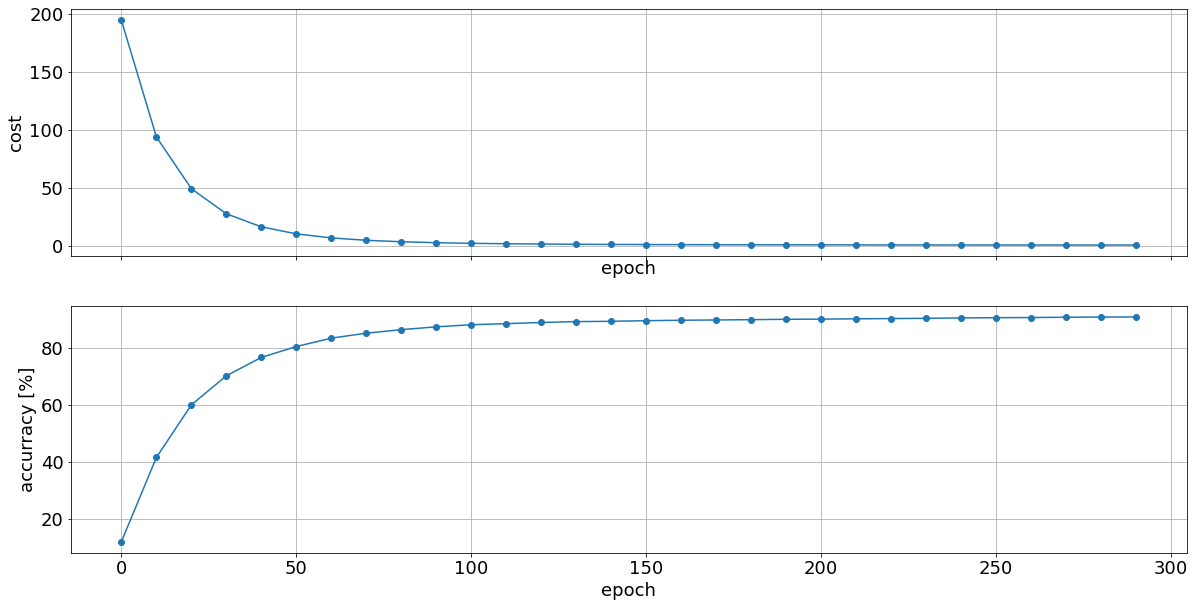

In [48]:
fig, ax = plt.subplots(2, 1, figsize=(20, 10), sharex=True)
ax[0].plot([x * 10 for x in range(len(values))], values, 'o-')
ax[0].set_xlabel('epoch') ; ax[0].set_ylabel('cost')
ax[0].grid()
ax[1].plot([x * 10 for x in range(len(accurracies))], accurracies, 'o-')
ax[1].set_xlabel('epoch') ; ax[1].set_ylabel('accurracy [%]')
ax[1].grid()
plt.show()

In [50]:
# Calculam acuratetea pentru setul de test
# Aceasta presupune sa numaram cate predictii se potrivesc cu realitatea si sa exprimam acest lucru procentual
pred = np.argmax(softmax(test_x_all_ext, theta), axis=1)
actual = np.argmax(test_y_all, axis=1)
equalities = np.sum(pred == actual)
print("Test accuracy: %2.2f%%" % ( 100.0 * equalities / pred.shape[0]))

Test accuracy: 90.82%


In [53]:
# Calculam vectorii predictiilor precum si vectorul realitatii
pred = np.argmax(softmax(test_x_all_ext, theta), axis=1)
actual = np.argmax(test_y_all, axis=1)

# Confusion matrix va avea la intersectia linie/coloana cate sample-uri din clasa data de numarul liniei
# au fost prezise ca fiind facand parte din clasa data de numarul coloanei
# k = nr de clase
# pe linie - actual
# pe coloana - predicted
conf_matrix = np.zeros((k, k), dtype = int)
for actual_value, pred_value in zip(actual, pred):
    conf_matrix[actual_value, pred_value] += 1

assert len(conf_matrix) == k
assert (sum(len(row) for row in conf_matrix)) == k ** 2

headers = ['CnfMat'] + [f'pred: {x}' for x in range(k)] + ['all a'] 
table = []
for i in range(k):
    table.append([f'act: {i}'] +  [f'{conf_matrix[i,j]}' for j in range(k)] + [conf_matrix[i].sum()])
table.append( ['all prd'] + [f'{conf_matrix[:,col].sum()}' for col in range(k)] + [f'{conf_matrix.sum()}'] )

tab.table(table, headers, width=7)

╭─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────╮
│  CnfMat │ pred: 0 │ pred: 1 │ pred: 2 │ pred: 3 │ pred: 4 │ pred: 5 │ pred: 6 │ pred: 7 │ pred: 8 │ pred: 9 │   all a │
├─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┤
│  act: 0 │     962 │       0 │       2 │       1 │       1 │       2 │       8 │       1 │       3 │       0 │     980 │
│  act: 1 │       0 │    1104 │       2 │       4 │       1 │       2 │       4 │       2 │      16 │       0 │    1135 │
│  act: 2 │      12 │      12 │     891 │      15 │      15 │       2 │      15 │      18 │      42 │      10 │    1032 │
│  act: 3 │       6 │       2 │      18 │     904 │       1 │      32 │       3 │      15 │      19 │      10 │    1010 │
│  act: 4 │       1 │       4 │       4 │       0 │     910 │       1 │      11 │       1 │       8 │      42 │     982 │
│  act: 5 │      14 │   